Accuracy:  75.0
Weighted F1 Score: 0.64


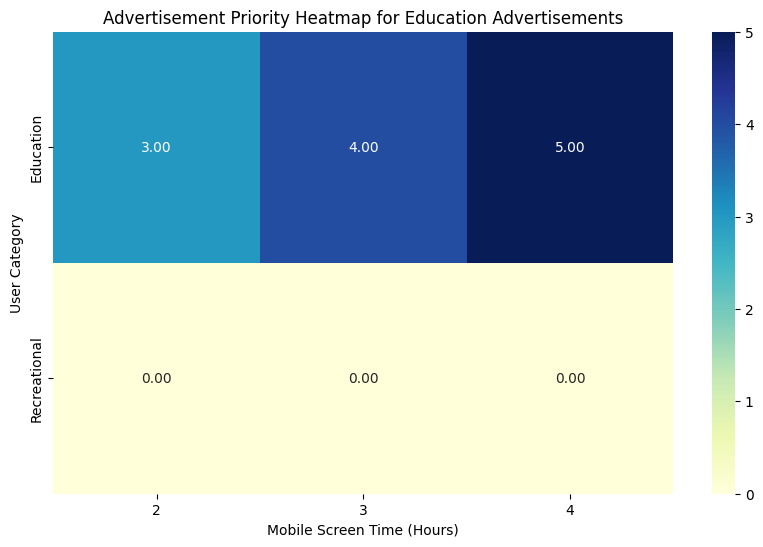

Age Group
<18        0.0
18-20    100.0
20-24      0.0
25-30      0.0
31-40      0.0
41+        0.0
Name: Budget Allocation, dtype: float64


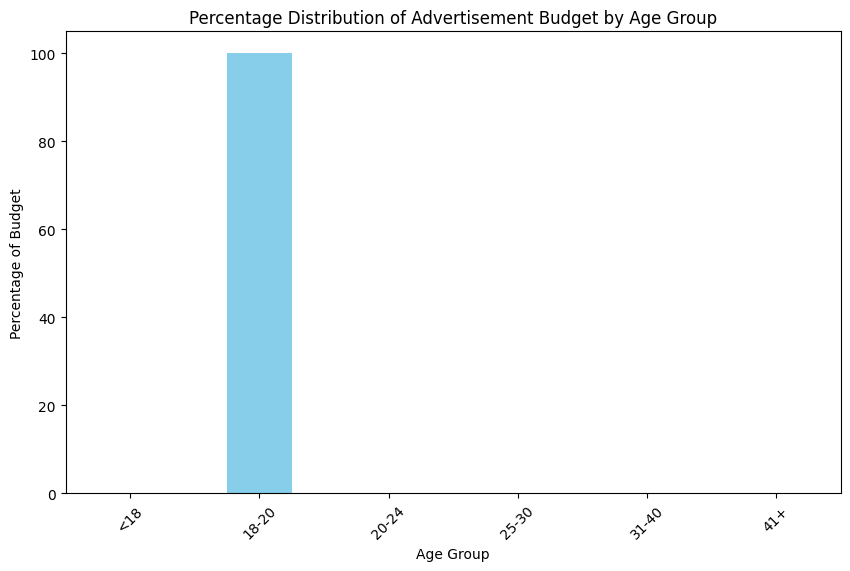

Top 5 Platforms for Web Browsing Habit 1:
Web Browsing Habit 1
YouTube            661.552055
Coding Websites    197.091288
Quora              -71.605670
LinkedIn           -72.308452
Coursera          -230.278212
Name: Habit 1 Score, dtype: float64

Top 5 Platforms for Web Browsing Habit 2:
Web Browsing Habit 2
Quora              353.622091
Coding Websites    229.565221
LinkedIn           -42.225162
Facebook           -87.941810
Netflix           -127.984793
Name: Habit 2 Score, dtype: float64

Top 5 Platforms for Web Browsing Habit 3:
Web Browsing Habit 3
Instagram          760.637243
Facebook           402.682486
Coding Websites     60.146501
YouTube             59.083138
Coursera           -92.911391
Name: Habit 3 Score, dtype: float64

Top 5 Social Media Platforms for Social Media Platform 1:
Social Media Platform 1
Instagram    176910.0
Twitter       83355.0
LinkedIn      30405.0
Facebook      14805.0
Reddit         3870.0
Name: Social Media 1 Score, dtype: float64

Top 5 Social M

: 

In [7]:
import pandas as pd

df = pd.read_csv('proj.csv')


#CLEANING
bins = [0, 18, 24, 30, 40, 60,100]
labels = ['<18', '18-20','20-24', '25-30', '31-40', '41+']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df = df.drop(columns=['Age'])


# Handle missing values
missing_value = ["N/A", "NILL", "None", " "]
df = df.fillna(method='ffill')

# Outliers in Mobile Screen Time
Q1 = df['Mobile Screen Time (Hours)'].quantile(0.25)#25% of the highest
Q3 = df['Mobile Screen Time (Hours)'].quantile(0.75)#75% of the lowest
IQR = Q3 - Q1
df = df[(df['Mobile Screen Time (Hours)'] >= Q1 - 1.5 * IQR) & (df['Mobile Screen Time (Hours)'] <= Q3 + 1.5 * IQR)]

# Create a dictionary to map web browsing habits to classes
habit_classes = {
    "Coursera": "Education",
    "LinkedIn": "Education",
    "Coding Websites": "Education",
    "Quora": "Education",
    "Netflix": "Recreational",
    "Facebook": "Recreational",
    "YouTube": "Recreational",
    "Amazon Prime Video": "Recreational",
    "Twitter": "Recreational",
    "Instagram": "Recreational",
}

# Loaded the data into a pandas DataFrame called 'df'
for i in range(1, 4):
    # Iterate through each of the three web browsing habits
    habit_col = f"Web Browsing Habit {i}"
    class_col = f"Web Browsing Habit {i} Class"
    
    # Use the dictionary to map the habits to classes
    df[class_col] = df[habit_col].map(habit_classes)

df['User Category'] = None

# Iterate through each user in the dataset
for user_id in df['Student ID'].unique():
    user_subset = df[df['Student ID'] == user_id]

    # Calculate the accumulated time for each habit class
    accumulated_time = {
        'Education': 0,
        'Recreational': 0
    }

    for i in range(1, 4):
        class_col = f"Web Browsing Habit {i} Class"
        time_col = f"Web Browsing Time {i} (Mins)"
        for habit_class in ['Education', 'Recreational']:
            accumulated_time[habit_class] += user_subset[user_subset[class_col] == habit_class][time_col].sum()

    # Assign the user category based on the habit class with the highest accumulated time
    user_category = max(accumulated_time, key=accumulated_time.get)
    
    # Update the 'User Category' column for this user
    df.loc[df['Student ID'] == user_id, 'User Category'] = user_category

#Data Discretization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

label_encoder = LabelEncoder()
df['Web Browsing Habit 1 Class'] = label_encoder.fit_transform(df['Web Browsing Habit 1 Class'])
df['Web Browsing Habit 2 Class'] = label_encoder.transform(df['Web Browsing Habit 2 Class'])
df['Web Browsing Habit 3 Class'] = label_encoder.transform(df['Web Browsing Habit 3 Class'])

scaler = StandardScaler()
habit_time_columns = ['Web Browsing Time 1 (Mins)', 'Web Browsing Time 2 (Mins)', 'Web Browsing Time 3 (Mins)']
df[habit_time_columns] = scaler.fit_transform(df[habit_time_columns])

X = df[['Web Browsing Habit 1 Class', 'Web Browsing Time 1 (Mins)',
        'Web Browsing Habit 2 Class', 'Web Browsing Time 2 (Mins)',
        'Web Browsing Habit 3 Class', 'Web Browsing Time 3 (Mins)']]
y = df['User Category']

#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the k-NN classifier
k = 8 # You can adjust the value of k as needed
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)

# Predict "User Category" for the test set
y_pred = knn_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy: ',accuracy*100)
print(f'Weighted F1 Score: {f1:.2f}')



#TRANSFORMATION
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ask the user for the type of advertisement
user_advertisement_type = input("Enter the type of advertisement (Education/Recreational): ").strip().title()

# Create a function to assign priority based on user preference and total screen time
def assign_priority(row):
    if row['User Category'] == user_advertisement_type:
        return 1 + row['Mobile Screen Time (Hours)']
    return 0

# Loaded the data into a pandas DataFrame called 'df'

# Create the 'Priority' field based on the function
df['Priority'] = df.apply(assign_priority, axis=1)

# Create a heatmap to visualize the priorities
heatmap_data = df.pivot_table(index='User Category', columns='Mobile Screen Time (Hours)', values='Priority', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title(f'Advertisement Priority Heatmap for {user_advertisement_type} Advertisements')
plt.show()

#Integration no need [already integrated].# BECAUSE THE TIME also plays a role further.
#Reduction not needed

# Calculate Attention Span Score
# You can define your own weighting scheme based on Mobile Screen Time and Total Web Time
df['Attention Span Score'] = df['Mobile Screen Time (Hours)'] + 0.5 * df['Total']

# Create a composite score (e.g., combining Priority and Attention Span Score)
df['Composite Score'] = 0.7 * df['Priority'] + 0.3 * df['Attention Span Score']


total_budget = int(input("Enter The Budget : "))  # Define the total budget
df['Budget Allocation'] = df.groupby('Age Group')['Composite Score'].transform(lambda x: (x / x.sum()) * total_budget)

# Calculate the percentage distribution of budget for each age group
budget_distribution = df.groupby('Age Group')['Budget Allocation'].sum()
percentage_distribution = (budget_distribution / total_budget) * 100

# Display the percentage distribution of budget for each age group
print(percentage_distribution)

import matplotlib.pyplot as plt

# Visualize the Budget Distribution
plt.figure(figsize=(10, 6))
percentage_distribution.plot(kind='bar', color='skyblue')
plt.title('Percentage Distribution of Advertisement Budget by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Budget')
plt.xticks(rotation=45)
plt.show()

# Calculate a score for each web browsing habit and social media site
# For example, you can calculate the score as (Attention Span Score) * (Time Spent on the Platform)
for i in range(1, 4):
    habit_col = f'Web Browsing Habit {i}'
    time_col = f'Web Browsing Time {i} (Mins)'
    df[f'Habit {i} Score'] = df['Attention Span Score'] * df[time_col]

for i in range(1, 3):
    platform_col = f'Social Media Platform {i}'
    time_col = f'Social Media Time {i} (Mins)'
    df[f'Social Media {i} Score'] = df['Attention Span Score'] * df[time_col]

# Find the top 5 platforms for advertisements based on the calculated scores
top_habits = []
top_social_media = []

for i in range(1, 4):
    habit_col = f'Web Browsing Habit {i}'
    habit_score_col = f'Habit {i} Score'
    top_habits.append((habit_col, df.groupby(habit_col)[habit_score_col].sum()))

for i in range(1, 3):
    platform_col = f'Social Media Platform {i}'
    platform_score_col = f'Social Media {i} Score'
    top_social_media.append((platform_col, df.groupby(platform_col)[platform_score_col].sum()))

# Display the top 5 platforms for advertisements
for habit_col, habit_scores in top_habits:
    top_habits = habit_scores.nlargest(5)
    print(f"Top 5 Platforms for {habit_col}:")
    print(top_habits)
    print()

for platform_col, platform_scores in top_social_media:
    top_platforms = platform_scores.nlargest(5)
    print(f"Top 5 Social Media Platforms for {platform_col}:")
    print(top_platforms)
    print()


print(df)
